# Analyzing the MSTIS simulation

Included in this notebook:

* Opening files for analysis
* Rates, fluxes, total crossing probabilities, and condition transition probabilities
* Per-ensemble properties such as path length distributions and interface crossing probabilities
* Move scheme analysis
* Replica exchange analysis
* Replica move history tree visualization
* Replaying the simulation
* MORE TO COME! Like free energy projections, path density plots, and more

In [8]:
storage.close()

In [1]:

%matplotlib inline
import matplotlib.pyplot as plt
import openpathsampling as paths
import numpy as np

The optimum way to use storage depends on whether you're doing production or analysis. For analysis, you should open the file as an `AnalysisStorage` object. This makes the analysis much faster.

In [2]:
%%time
storage = paths.AnalysisStorage("ala_mstis_production.nc")
engine = storage.engines['default']
platform = 'CUDA' #CUDA
engine.initialize(platform)

Warning on use of the timeseries module: If the inherent timescales of the system are long compared to those being analyzed, this statistical inefficiency may be an underestimate.  The estimate presumes the use of many statistically independent samples.  Tests should be performed to assess whether this condition is satisfied.   Be cautious in the interpretation of the data.

********* JAX NOT FOUND *********
 PyMBAR can run faster with JAX  
 But will work fine without it   
Either install with pip or conda:
      pip install pybar[jax]     
               OR                
      conda install pymbar       
*********************************


CPU times: user 1min 22s, sys: 6.04 s, total: 1min 28s
Wall time: 3min 28s


In [3]:
print("PathMovers:", len(storage.pathmovers))
print("Engines:", len(storage.engines))
print("Samples:", len(storage.samples))
print("Ensembles:", len(storage.ensembles))
print("SampleSets:", len(storage.samplesets))
print("Snapshots:", len(storage.snapshots))
print("Trajectories:", len(storage.trajectories))
print("Networks:", len(storage.networks))

PathMovers: 125
Engines: 3
Samples: 65414
Ensembles: 315
SampleSets: 50001
Snapshots: 1956966
Trajectories: 39690
Networks: 1


In [4]:
%%time
mstis = storage.networks[0]

CPU times: user 11 µs, sys: 1 µs, total: 12 µs
Wall time: 15 µs


In [5]:
%%time
for cv in storage.cvs:
    print(cv.name, cv._store_dict)

max opA <openpathsampling.netcdfplus.chaindict.StoredDict object at 0x7f2a61519d20>
opA None
phi <openpathsampling.netcdfplus.chaindict.StoredDict object at 0x7f2a6196af80>
psi <openpathsampling.netcdfplus.chaindict.StoredDict object at 0x7f2a61519ba0>
opD None
opC None
opB None
max opB <openpathsampling.netcdfplus.chaindict.StoredDict object at 0x7f2a6151a4a0>
max opC <openpathsampling.netcdfplus.chaindict.StoredDict object at 0x7f2a6151a770>
max opD <openpathsampling.netcdfplus.chaindict.StoredDict object at 0x7f2a6151aa40>
CPU times: user 221 µs, sys: 0 ns, total: 221 µs
Wall time: 210 µs


## Reaction rates

TIS methods are especially good at determining reaction rates, and OPS makes it extremely easy to obtain the rate from a TIS network.

Note that, although you can get the rate directly, it is very important to look at other results of the sampling (illustrated in this notebook and in notebooks referred to herein) in order to check the validity of the rates you obtain.

By default, the built-in analysis calculates histograms the maximum value of some order parameter and the pathlength of every sampled ensemble. You can add other things to this list as well, but you must always specify histogram parameters for these two. The pathlength is in units of frames.

In [6]:
mstis.hist_args['max_lambda'] = { 'bin_width' : 10, 'bin_range' : (0.0, 90) }
mstis.hist_args['pathlength'] = { 'bin_width' : 20, 'bin_range' : (0, 100) }

In [7]:
%%time
mstis.rate_matrix(storage.steps, force=True)

/usr/local/miniconda3/lib/python3.10/site-packages/openpathsampling/numerics/wham.py:191: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  unweighting = cleaned_df.copy().applymap(
/usr/local/miniconda3/lib/python3.10/site-packages/openpathsampling/numerics/wham.py:191: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  unweighting = cleaned_df.copy().applymap(
/usr/local/miniconda3/lib/python3.10/site-packages/openpathsampling/numerics/wham.py:191: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  unweighting = cleaned_df.copy().applymap(
/usr/local/miniconda3/lib/python3.10/site-packages/openpathsampling/numerics/wham.py:191: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  unweighting = cleaned_df.copy().applymap(


CPU times: user 1min 4s, sys: 8.56 s, total: 1min 13s
Wall time: 4min 44s


,A,B,C,D
A,NaN,0.0828460455999419 /ps,0.004077475447764626 /ps,0.0028365046593145224 /ps
B,0.12327373683852032 /ps,NaN,0.001470796246581971 /ps,0.0007233916233188877 /ps
C,0.026148026811125248 /ps,0.0048389035888592394 /ps,NaN,0.13539266047344523 /ps
D,0.0068527953220901 /ps,0.004940149463536596 /ps,0.13456537560459464 /ps,NaN


The self-rates (the rate of returning the to initial state) are undefined, and return not-a-number.

The rate is calcuated according to the formula:

$$k_{AB} = \phi_{A,0} P(B|\lambda_m) \prod_{i=0}^{m-1} P(\lambda_{i+1} | \lambda_i)$$

where $\phi_{A,0}$ is the flux from state A through its innermost interface, $P(B|\lambda_m)$ is the conditional transition probability (the probability that a path which crosses the interface at $\lambda_m$ ends in state B), and $\prod_{i=0}^{m-1} P(\lambda_{i+1} | \lambda_i)$ is the total crossing probability. We can look at each of these terms individually.

### Total crossing probability

In [9]:
stateA = storage.volumes["A"]
stateB = storage.volumes["B"]
stateC = storage.volumes["C"]

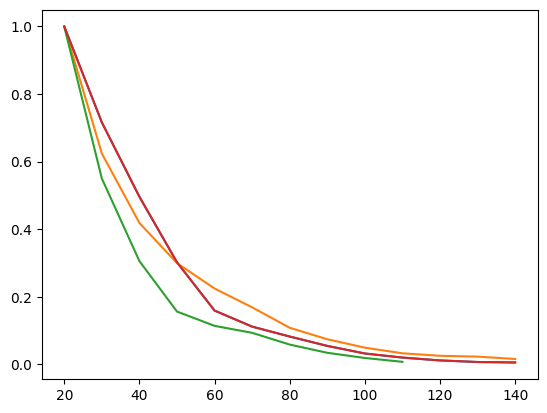

In [10]:
tcp_AB = mstis.transitions[(stateA, stateB)].tcp
tcp_AC = mstis.transitions[(stateA, stateC)].tcp
tcp_BC = mstis.transitions[(stateB, stateC)].tcp
tcp_BA = mstis.transitions[(stateB, stateA)].tcp
tcp_CA = mstis.transitions[(stateC, stateA)].tcp
tcp_CB = mstis.transitions[(stateC, stateB)].tcp

plt.plot(tcp_AB.x, tcp_AB)
plt.plot(tcp_CA.x, tcp_CA)
plt.plot(tcp_BC.x, tcp_BC)
plt.plot(tcp_AC.x, tcp_AC) # same as tcp_AB in MSTIS

We normally look at these on a log scale:

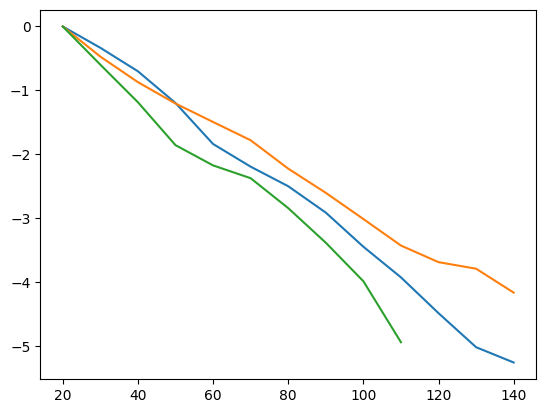

In [11]:
plt.plot(tcp_AB.x, np.log(tcp_AB))
plt.plot(tcp_CA.x, np.log(tcp_CA))
plt.plot(tcp_BC.x, np.log(tcp_BC))

### Flux

Here we also calculate the flux contribution to each transition. The flux is calculated based on

In [12]:
import pandas as pd
flux_matrix = pd.DataFrame(columns=mstis.states, index=mstis.states)
for state_pair in mstis.transitions:
    transition = mstis.transitions[state_pair]
    flux_matrix.at[state_pair[0], state_pair[1]] = transition._flux

flux_matrix

AttributeError: 'CVDefinedVolume' object has no attribute '_reversed'

### Conditional transition probability

In [10]:
outer_ctp_matrix = pd.DataFrame(columns=mstis.states, index=mstis.states)
for state_pair in mstis.transitions:
    transition = mstis.transitions[state_pair]
    outer_ctp_matrix.at[state_pair[0], state_pair[1]] = transition.ctp[transition.ensembles[-1]]

outer_ctp_matrix

NameError: name 'pd' is not defined

## Path ensemble properties

In [13]:
hists_A = mstis.transitions[(stateA, stateB)].histograms
hists_B = mstis.transitions[(stateB, stateC)].histograms
hists_C = mstis.transitions[(stateC, stateB)].histograms

### Interface crossing probabilities

We obtain the total crossing probability, shown above, by combining the individual crossing probabilities of

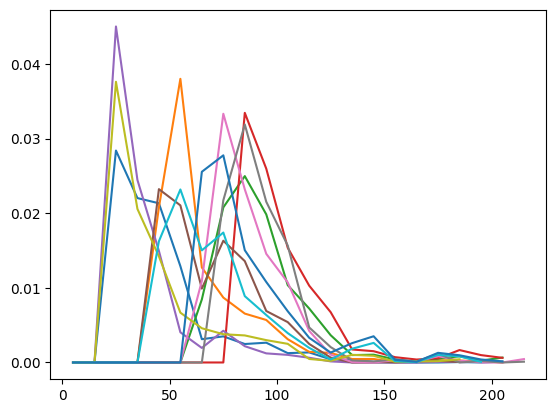

In [14]:
for hist in [hists_A, hists_B, hists_C]:
    for ens in hist['max_lambda']:
        normalized = hist['max_lambda'][ens].normalized()
        plt.plot(normalized.x, normalized)

In [44]:
# add visualization of the sum

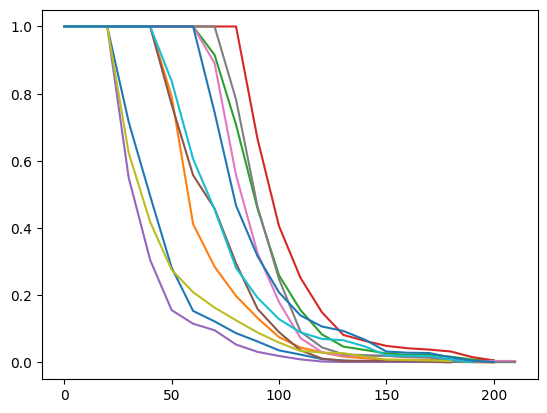

In [15]:
for hist in [hists_A, hists_B, hists_C]:
    for ens in hist['max_lambda']:
        reverse_cumulative = hist['max_lambda'][ens].reverse_cumulative()
        plt.plot(reverse_cumulative.x, reverse_cumulative)

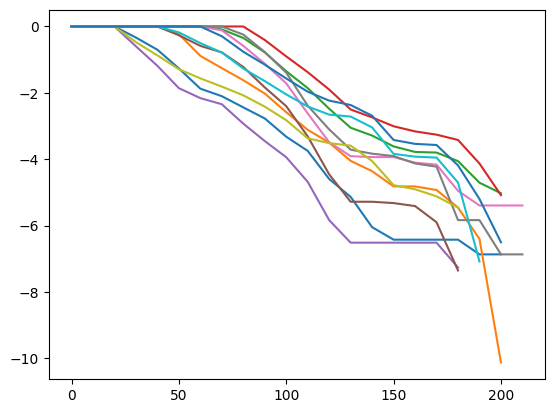

In [16]:
for hist in [hists_A, hists_B, hists_C]:
    for ens in hist['max_lambda']:
        reverse_cumulative = hist['max_lambda'][ens].reverse_cumulative()
        plt.plot(reverse_cumulative.x, np.log(reverse_cumulative))

### Path length histograms

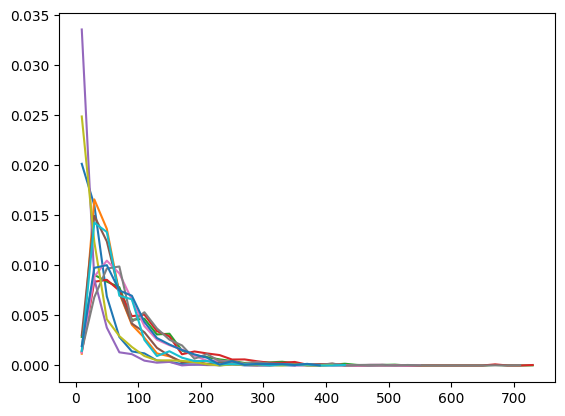

In [17]:
for hist in [hists_A, hists_B, hists_C]:
    for ens in hist['pathlength']:
        normalized = hist['pathlength'][ens].normalized()
        plt.plot(normalized.x, normalized)

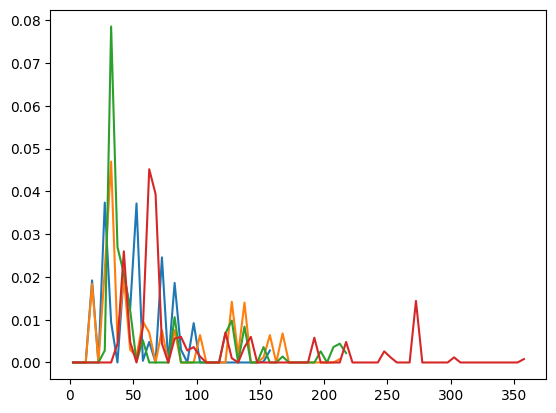

In [48]:
for ens in hists_A['pathlength']:
    normalized = hists_A['pathlength'][ens].normalized()
    plt.plot(normalized.x, normalized)

## Sampling properties

The properties we illustrated above were properties of the path ensembles. If your path ensembles are sufficiently well-sampled, these will never depend on how you sample them.

But to figure out whether you've done a good job of sampling, you often want to look at properties related to the sampling process. OPS also makes these very easy.

### Move scheme analysis

In [18]:
scheme = storage.schemes[0]

In [61]:
scheme.move_summary(storage.steps)

  0%|          | 0/1001 [00:00<?, ?it/s]

repex ran 23.900% (expected 23.10%) of the cycles with acceptance 119/239 (49.79%)
shooting ran 45.000% (expected 46.20%) of the cycles with acceptance 297/450 (66.00%)
pathreversal ran 25.300% (expected 24.75%) of the cycles with acceptance 105/253 (41.50%)
minus ran 2.700% (expected 2.64%) of the cycles with acceptance 19/27 (70.37%)
ms_outer_shooting ran 3.100% (expected 3.30%) of the cycles with acceptance 20/31 (64.52%)


In [62]:
scheme.move_summary(storage.steps, 'shooting')

OneWayShootingMover Out A 0 ran 3.400% (expected 3.30%) of the cycles with acceptance 25/34 (73.53%)
OneWayShootingMover Out A 1 ran 3.400% (expected 3.30%) of the cycles with acceptance 23/34 (67.65%)
OneWayShootingMover Out A 2 ran 2.500% (expected 3.30%) of the cycles with acceptance 20/25 (80.00%)
OneWayShootingMover Out A 3 ran 4.900% (expected 3.30%) of the cycles with acceptance 25/49 (51.02%)
OneWayShootingMover Out B 0 ran 2.200% (expected 3.30%) of the cycles with acceptance 17/22 (77.27%)
OneWayShootingMover Out B 1 ran 3.800% (expected 3.30%) of the cycles with acceptance 29/38 (76.32%)
OneWayShootingMover Out B 2 ran 3.900% (expected 3.30%) of the cycles with acceptance 22/39 (56.41%)
OneWayShootingMover Out B 3 ran 2.300% (expected 3.30%) of the cycles with acceptance 11/23 (47.83%)
OneWayShootingMover Out C 0 ran 3.100% (expected 3.30%) of the cycles with acceptance 21/31 (67.74%)
OneWayShootingMover Out C 1 ran 3.400% (expected 3.30%) of the cycles with acceptance 24/34

/Users/matteo/.local/share/virtualenvs/quantum-folding-aHaLeqp8/lib/python3.11/site-packages/openpathsampling/high_level/move_scheme.py:890: UserWarning: Move acceptance already calculated. The steps parameter will be ignored.
  warnings.warn("Move acceptance already calculated. "


In [63]:
scheme.move_summary(storage.steps, 'minus')

Minus ran 0.800% (expected 0.66%) of the cycles with acceptance 4/8 (50.00%)
Minus ran 0.900% (expected 0.66%) of the cycles with acceptance 9/9 (100.00%)
Minus ran 0.400% (expected 0.66%) of the cycles with acceptance 2/4 (50.00%)
Minus ran 0.600% (expected 0.66%) of the cycles with acceptance 4/6 (66.67%)


/Users/matteo/.local/share/virtualenvs/quantum-folding-aHaLeqp8/lib/python3.11/site-packages/openpathsampling/high_level/move_scheme.py:890: UserWarning: Move acceptance already calculated. The steps parameter will be ignored.
  warnings.warn("Move acceptance already calculated. "


In [64]:
scheme.move_summary(storage.steps, 'repex')

ReplicaExchange ran 1.000% (expected 1.65%) of the cycles with acceptance 10/10 (100.00%)
ReplicaExchange ran 2.100% (expected 1.65%) of the cycles with acceptance 20/21 (95.24%)
ReplicaExchange ran 1.600% (expected 1.65%) of the cycles with acceptance 2/16 (12.50%)
ReplicaExchange ran 1.900% (expected 1.65%) of the cycles with acceptance 10/19 (52.63%)
ReplicaExchange ran 2.500% (expected 1.65%) of the cycles with acceptance 12/25 (48.00%)
ReplicaExchange ran 2.400% (expected 1.65%) of the cycles with acceptance 21/24 (87.50%)
ReplicaExchange ran 1.600% (expected 1.65%) of the cycles with acceptance 6/16 (37.50%)
ReplicaExchange ran 1.400% (expected 1.65%) of the cycles with acceptance 7/14 (50.00%)
ReplicaExchange ran 1.300% (expected 1.65%) of the cycles with acceptance 3/13 (23.08%)
ReplicaExchange ran 1.200% (expected 1.65%) of the cycles with acceptance 9/12 (75.00%)
ReplicaExchange ran 1.800% (expected 1.65%) of the cycles with acceptance 13/18 (72.22%)
ReplicaExchange ran 1.800

/Users/matteo/.local/share/virtualenvs/quantum-folding-aHaLeqp8/lib/python3.11/site-packages/openpathsampling/high_level/move_scheme.py:890: UserWarning: Move acceptance already calculated. The steps parameter will be ignored.
  warnings.warn("Move acceptance already calculated. "


In [65]:
scheme.move_summary(storage.steps, 'pathreversal')

PathReversal ran 1.500% (expected 1.65%) of the cycles with acceptance 7/15 (46.67%)
PathReversal ran 2.400% (expected 1.65%) of the cycles with acceptance 8/24 (33.33%)
PathReversal ran 1.500% (expected 1.65%) of the cycles with acceptance 5/15 (33.33%)
PathReversal ran 2.500% (expected 1.65%) of the cycles with acceptance 11/25 (44.00%)
PathReversal ran 1.400% (expected 1.65%) of the cycles with acceptance 13/14 (92.86%)
PathReversal ran 1.400% (expected 1.65%) of the cycles with acceptance 2/14 (14.29%)
PathReversal ran 2.200% (expected 1.65%) of the cycles with acceptance 3/22 (13.64%)
PathReversal ran 2.200% (expected 1.65%) of the cycles with acceptance 1/22 (4.55%)
PathReversal ran 1.400% (expected 1.65%) of the cycles with acceptance 12/14 (85.71%)
PathReversal ran 1.600% (expected 1.65%) of the cycles with acceptance 7/16 (43.75%)
PathReversal ran 1.500% (expected 1.65%) of the cycles with acceptance 1/15 (6.67%)
PathReversal ran 2.200% (expected 1.65%) of the cycles with acce

/Users/matteo/.local/share/virtualenvs/quantum-folding-aHaLeqp8/lib/python3.11/site-packages/openpathsampling/high_level/move_scheme.py:890: UserWarning: Move acceptance already calculated. The steps parameter will be ignored.
  warnings.warn("Move acceptance already calculated. "


### Replica exchange sampling

See the notebook `repex_networks.ipynb` for more details on tools to study the convergence of replica exchange. However, a few simple examples are shown here. All of these are analyzed with a separate object, `ReplicaNetwork`.

In [19]:
repx_net = paths.ReplicaNetwork(scheme, storage.steps)

#### Replica exchange mixing matrix

In [20]:
repx_net.mixing_matrix()

,Out B minus,Out A minus,Out D minus,Out B 0,Out A 0,Out D 0,Out B 1,Out A 1,Out D 1,Out B 2,Out A 2,Out D 2,Out B 3,Out A 3,[UnionEnsemble],Out C 2,Out C 1,Out C 0,Out C minus
Out B minus,0.000000,0.000000,0.000000,0.021536,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Out A minus,0.000000,0.000000,0.000000,0.000000,0.022469,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Out D minus,0.000000,0.000000,0.000000,0.000000,0.000000,0.022858,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Out B 0,0.021536,0.000000,0.000000,0.000000,0.000000,0.000000,0.014228,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Out A 0,0.000000,0.022469,0.000000,0.000000,0.000000,0.000000,0.000000,0.023325,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Out D 0,0.000000,0.000000,0.022858,0.000000,0.000000,0.000000,0.000000,0.000000,0.011507,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Out B 1,0.000000,0.000000,0.000000,0.014228,0.000000,0.000000,0.000000,0.000000,0.000000,0.031333,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Out A 1,0.000000,0.000000,0.000000,0.000000,0.023325,0.000000,0.000000,0.000000,0.000000,0.000000,0.019670,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Out D 1,0.000000,0.000000,0.000000,0.000000,0.000000,0.011507,0.000000,0.000000,0.000000,0.000000,0.000000,0.037164,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Out B 2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.031333,0.000000,0.000000,0.000000,0.000000,0.000000,0.045016,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


#### Replica exchange graph

The mixing matrix tells a story of how well various interfaces are connected to other interfaces. The replica exchange graph is essentially a visualization of the mixing matrix (actually, of the transition matrix -- the mixing matrix is a symmetrized version of the transition matrix).

Note: We're still developing better layout tools to visualize these.

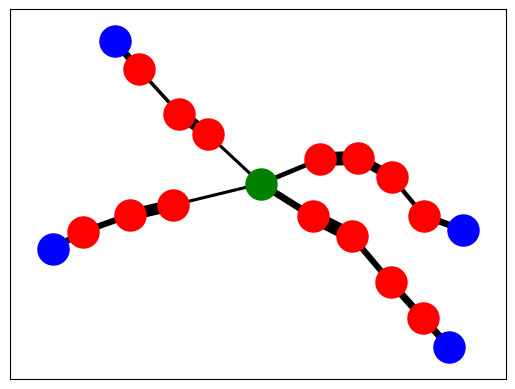

In [21]:
repxG = paths.ReplicaNetworkGraph(repx_net)
repxG.draw('spring')

#### Replica exchange flow

Replica flow is defined as ***TODO***

Flow is designed for calculations where the replica exchange graph is linear, which ours clearly is not. However, we can define the flow over a subset of the interfaces.

### Replica move history tree

In [22]:
import openpathsampling.visualize as vis
#reload(vis)
from IPython.display import SVG

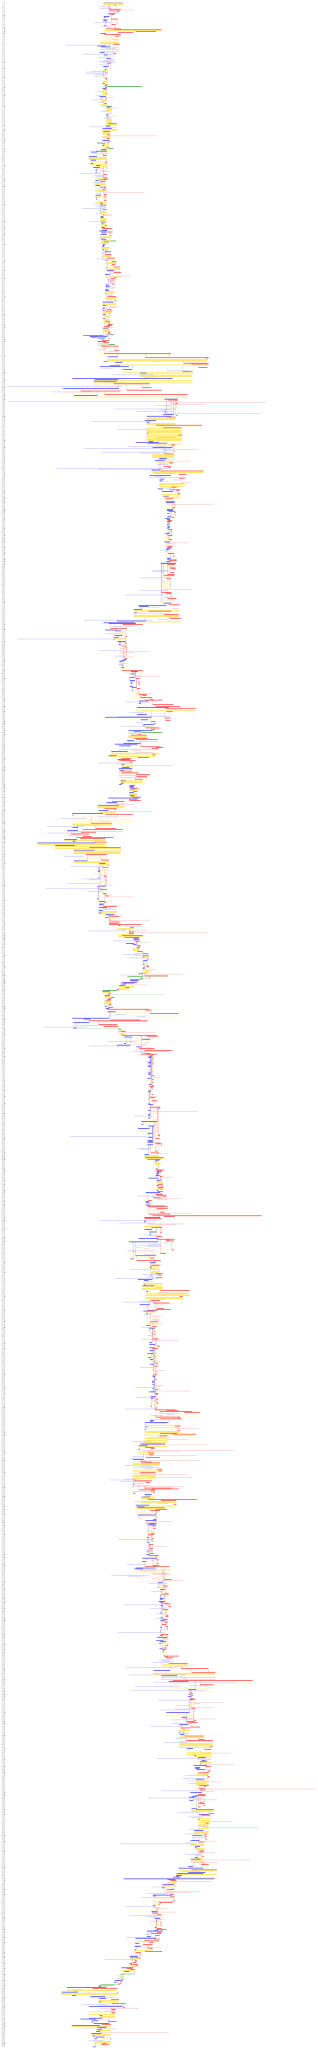

In [23]:
tree = vis.PathTree(
    [step for step in storage.steps if not isinstance(step.change, paths.EmptyMoveChange)],
    vis.ReplicaEvolution(replica=3, accepted=False)
)
tree.options.css['width'] = 'inherit'

SVG(tree.svg())

In [24]:
decorrelated = tree.generator.decorrelated
print ("We have " + str(len(decorrelated)) + " decorrelated trajectories.")

We have 218 decorrelated trajectories.


### Visualizing trajectories

## Histogramming data (TODO)

In [25]:
storage.close()
